### HW 2 - dask & xarray for computing weather and climate diagnostics

##### (1) Use the precipitation output of ERA-5 to compute a time series of daily precipitation at a given point closest to a city of your choosing. Choose a box of 5 x 5 deg lat-lon values over the grid box closest to the city you are examining. Save this data. Use a period of at least 10 years.

In [15]:
# libraries 
import xarray as xr
import pandas as pd
import numpy as np
import dask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
"""Below codes to import data are taken from Module 2 in-class activity"""

# set up local cluster on your machine
from dask.distributed import Client
client = Client()  
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38799,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45039,Total threads: 1
Dashboard: http://127.0.0.1:33555/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:41941,


In [4]:
# open a Zarr v3 store with anonymous GCS access
import gcsfs
fs = gcsfs.GCSFileSystem(token="anon")

In [5]:
# import data from Zarr as an xarray Dataset within data time range
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)
ds = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))
ds

<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 748008,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 3TB ...
Attributes:
    last_updated:           2025-09-26 02:01:41.936564+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-20

In [9]:
# find relevant precipitation variable name: total_precipitation
print(np.array([s for s in list(ds.data_vars) if 'prec' in s]))

# subset 10 yr time slice of only total_precipitation variable
prec = ds.total_precipitation.sel(time=slice('2010-01-01 00:00','2020-01-01 00:00'))

['convective_precipitation'
 'instantaneous_large_scale_surface_precipitation_fraction'
 'large_scale_precipitation' 'large_scale_precipitation_fraction'
 'maximum_total_precipitation_rate_since_previous_post_processing'
 'mean_convective_precipitation_rate'
 'mean_large_scale_precipitation_fraction'
 'mean_large_scale_precipitation_rate' 'mean_total_precipitation_rate'
 'minimum_total_precipitation_rate_since_previous_post_processing'
 'precipitation_type' 'total_precipitation']


Text(0.5, 1.0, 'Daily Precipitation near Palm Springs, CA from 2010 to 2020')

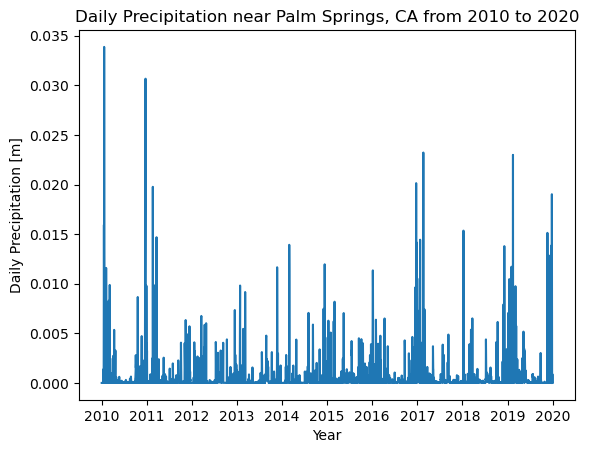

In [10]:
# subset 5x5 lat-lon grid centered at Palm Springs, California from latlong.net
ps_lat, ps_lon = 33.830517, -116.545601 + 360
prec_pm = prec.sel(latitude=slice(ps_lat+2.5, ps_lat-2.5), 
                   longitude=slice(ps_lon-2.5, ps_lon+2.5))

# calculate daily total precipitation by resampling to daily frequency
prec_pm = prec_pm.resample(time='24h').sum().compute()
prec_pm.to_netcdf('prec_pm_daily.nc')
prec_pm_ts = prec_pm.mean(dim=('latitude','longitude')).compute()

# basic plot of time series with labels and title
plt.plot(prec_pm_ts.time, prec_pm_ts.values)
plt.xlabel('Year')
plt.ylabel('Daily Precipitation [m]')
plt.title('Daily Precipitation near Palm Springs, CA from 2010 to 2020')

In [9]:
# save time series to netcdf file
prec_pm_ts.to_netcdf('final_part1_timeseries.nc')

##### (2) Determine the 95% values of daily precipitation for the data created in (1). Plot a cumulative distribution function of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

In [11]:
# print statement of 95th percentil of daily precipitation in Palm Springs, CA
prec95 = prec_pm_ts.quantile(0.95).compute().values.tolist()*1000
print('95% Percentile of Daily Precipitation near Palm Springs, CA: ' 
      + str(round(prec95, 2)) + ' mm')

95% Percentile of Daily Precipitation near Palm Springs, CA: 2.97 mm


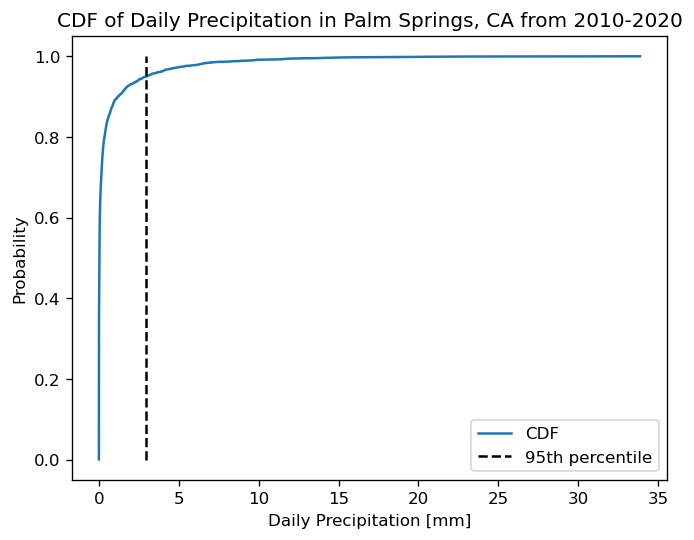

In [80]:
'''Use built-in CDF function from statsmodel library to plot time series CDF'''

# import CDF function
from statsmodels.distributions.empirical_distribution import ECDF

# CDF function of precipitation time series
cdf = ECDF(prec_pm_ts.values)

# basic line plot of CDF with a dashed line for the 95th percentile
plt.plot(cdf.x*1000, cdf.y, label='CDF')
# 95th percentile
plt.plot([prec95, prec95], [0, 1], '--k', label='95th percentile')
plt.xlabel('Daily Precipitation [mm]')
plt.ylabel('Probability')
plt.title('CDF of Daily Precipitation in Palm Springs, CA from 2010-2020')
plt.legend()

##### (3) Create a map of the composite mean precipitation on the 95% days identified in (2) over the continental USA, and a map of the anomaly of precipitation from the *1990-2020* mean. This field should be plotted on a Cartopy map centered at your city with a 40 x 40 degree lat-lon range.

In [82]:
!wget https://www.atmos.illinois.edu/~snesbitt/data/ERA-5_total_precipitation_monthly-1981-2020.nc

--2025-09-24 18:28:08--  https://www.atmos.illinois.edu/~snesbitt/data/ERA-5_total_precipitation_monthly-1981-2020.nc
Resolving www.atmos.illinois.edu (www.atmos.illinois.edu)... 128.174.76.242
Connecting to www.atmos.illinois.edu (www.atmos.illinois.edu)|128.174.76.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 509932928 (486M) [application/x-netcdf]
Saving to: ‘ERA-5_total_precipitation_monthly-1981-2020.nc’

ERA-5_total_precipi 100%[===================>] 486.31M  73.1MB/s    in 6.6s    

2025-09-24 18:28:15 (73.4 MB/s) - ‘ERA-5_total_precipitation_monthly-1981-2020.nc’ saved [509932928/509932928]



In [12]:
# ERA5 monthly precipitation totals (calculated for us due to long comp. times)
ds_climo = xr.open_dataset('ERA-5_total_precipitation_monthly-1981-2020.nc')
ds_climo

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 372, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 1990-01-01T06:00:00 ... 2020-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 6kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-22T22:03 GRIB to CDM+CF via cfgrib-0.9.1...

In [54]:
# subset data for 40x40 deg boundary box around Palm Springs, CA
ds_climo_ps = ds_climo.sel(
    latitude=slice(ps_lat+20, ps_lat-20),
    longitude=slice(ps_lon-20, ps_lon+20))

# find nearest month in ds_climo to each 95th percentile day
# of ERA5 daily precip totals in Palm Springs
ds_climo_ps95 = ds_climo_ps.sel(
    valid_time = np.unique(prec_pm_ts.time.where(
        prec_pm_ts*1000 >= prec95).values),
    method="nearest")

# Mean composite of 95% percentile days of daily precip in ds_climo
ds_climo_ps95_mean = ds_climo_ps95.mean(dim='valid_time').compute()

In [48]:
# make map function
def make_map(data, title, res, pt_col, marker, plon, plat,
        cmap_title, cmap='RdYlGn_r'):

    # create longitude and latitude ranges
    lon_range = np.arange(data.longitude.min(), 
        data.longitude.max()+res, res)
    lat_range = np.flip(np.arange(data.latitude.min(),
        data.latitude.max()+res, res))
    print(len(lat_range), len(lon_range))
    # create 2D grid
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)

    # projection
    proj = ccrs.PlateCarree()

    # figure
    fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection=proj))

    # add title, axis labels, and coastlines
    ax.coastlines()

    # add gridded data and colorbar
    cs = ax.contourf(lon_grid, lat_grid, data, 10,
        cmap=cmap, transform=proj, extend='both')
    cb = fig.colorbar(cs,shrink=0.22)
    cb.set_label(cmap_title)
    # add point data
    ax.scatter(plon, plat, transform=proj, marker=marker, c=pt_col)
    
    # title
    ax.set_title(title)
    # add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    #ax.set_ylim(48,72); ax.set_xlim(-80,40)

160 160


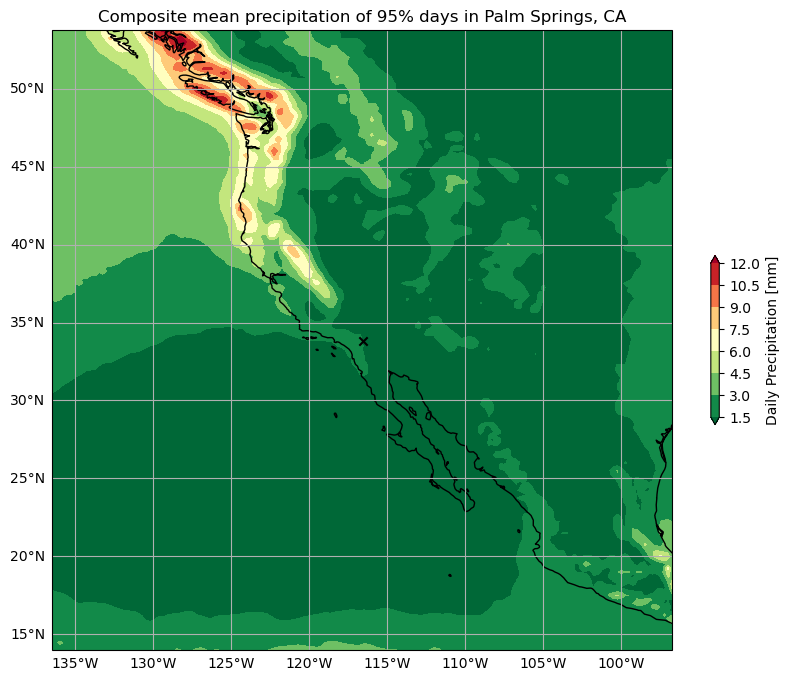

In [51]:
# Composite mean precipitation of 95% days in Palm Springs, CA
make_map(
    data=ds_climo_ps95_mean.tp*1000, 
    title='Composite mean precipitation of 95% days in Palm Springs, CA',
    marker='x',
    pt_col='k',
    res=0.25,
    plon=ps_lon,
    plat=ps_lat,
    cmap_title="Daily Precipitation [mm]")

160 160


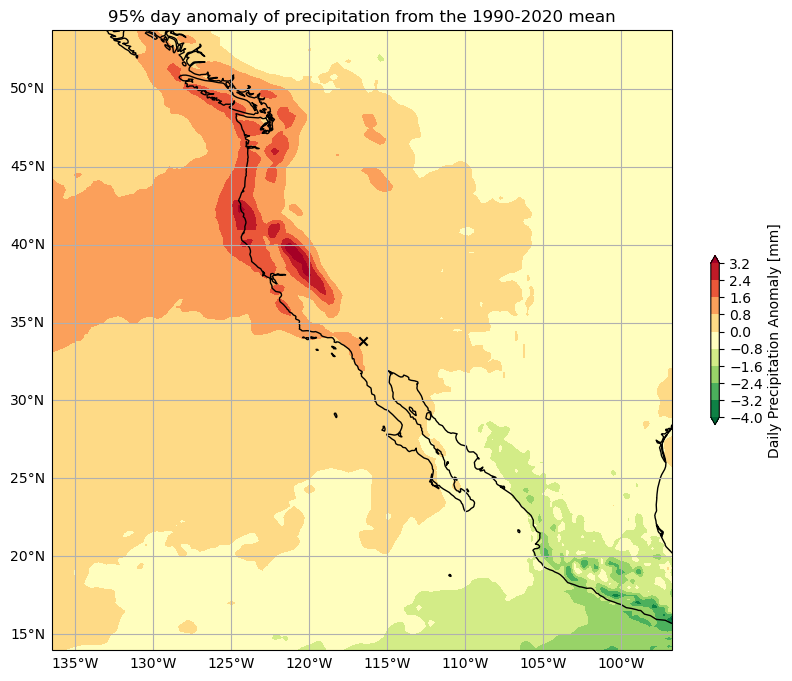

In [56]:
# 30-yr LTM of monthly precipitation from 1990-2020 
ltm30_ds_climo = ds_climo_ps.mean(dim='valid_time')*1000
#(ds_climo_ps_1020.mean(dim='valid_time')*1000).tp.plot()
# Anomaly of 95% day mean precipitation from 30-yr LTM
anom_ps95_ds_climo = ds_climo_ps95_mean.tp*1000 - ltm30_ds_climo

# Composite mean precipitation of 95% days in Palm Springs, CA
make_map(
    data=anom_ps95_ds_climo.tp,#ds_climo_ps95_mean.tp*1000, 
    title='95% day anomaly of precipitation from the 1990-2020 mean',
    marker='x',
    pt_col='k',
    res=0.25,
    plon=ps_lon,
    plat=ps_lat,
    cmap_title="Daily Precipitation Anomaly [mm]")